In [1]:
# use tf_env
import sys
sys.path.append('../source')
import get_data, methyl_and_mut_clocks, mutation_clocks

import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import statsmodels.formula.api as smf
import json

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

my_palette= ['darkgrey', 'steelblue', 'maroon', 'darkgoldenrod', 'lightgrey', 'lightblue', 'salmon', 'wheat']
dsets = ['LGG', 'THCA', 'GBM', 'SARC', 'KIRP']
order = ['All'] + dsets
fig_out_dir = "../figures/figure5"

# Read in clock predictions and models

In [4]:
def read_in_trained_clock_perf(out_dir:str, separate:bool=False):
    
    model_dict = {}
    feat_dict = {}
    fmap_paths = {}
    predictions_df = {}
    parameters_dict = {}
    
    for file in glob.glob(out_dir + "/*.pkl"):
        with open(file, 'rb'):
            model_dict[int(file.split("_")[-1].split(".")[0])] = pd.read_pickle(file)
    # read each features parquet file into dictionary and create fmap
    for file in glob.glob(out_dir + "/*features.parquet"):
        cv_num = int(file.split("_")[-2])
        feat_dict[cv_num] = pd.read_parquet(file)
        # write to fmap
        fmap_df = feat_dict[cv_num].reset_index()
        fmap_df['feat_type'] = 'q' # i for indicator, q for quantity
        fmap_df.to_csv(os.path.join(out_dir, "fmap_" + str(cv_num) + ".txt"), sep = '\t', header=False, index=False)
        fmap_paths[cv_num] = os.path.join(out_dir, "fmap_" + str(cv_num) + ".txt")
    # read in the predictions df
    predictions_fn = glob.glob(out_dir + "/*clock_predictions.parquet")
    predictions_df = pd.read_parquet(predictions_fn[0])
    
    with open(os.path.join(out_dir, "parameters.json"), 'r') as f:
        parameters = json.load(f)
    parameters_dict[out_dir] = parameters
        
    return model_dict, feat_dict, fmap_paths, predictions_df, parameters
    
    
def make_plots(mut_df, mut_and_methyl_df, is_combined = False, corr_method = 'pearson'):
    # make middle subplot half size of others
    fig, axes = plt.subplots(1,3, figsize=(16,5), gridspec_kw={'width_ratios': [1, .3, 1]})
    # lm plot of normal tissue age vs. mut age
    if is_combined:
        #sns.regplot(mut_df, x = 'age_at_index', y='mut_age', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True},line_kws={'color':'black'}, ax = axes[0])
        sns.histplot(x = 'age_at_index', y='mut_age',  data = mut_df, ax = axes[0], bins = 50, pthresh = 0.1, cmap = 'coolwarm', cbar = True, cbar_kws = {'label': 'Density'}, rasterized = True)
        if corr_method == 'pearson':
            r, p = pearsonr(mut_df.query("tissue_type == 'normal'")['age_at_index'], mut_df.query("tissue_type == 'normal'")['mut_age'])
            axes[0].text(0.05, 0.85, f"normal r = {r:.2f}\np = {p:.2e}", transform=axes[0].transAxes)
            r, p = pearsonr(mut_df.query("tissue_type == 'cancer'")['age_at_index'], mut_df.query("tissue_type == 'cancer'")['mut_age'])
            axes[0].text(0.05, 0.75, f"cancer r = {r:.2f}\np = {p:.2e}", transform=axes[0].transAxes)
        else:
            r, p = spearmanr(mut_df.query("tissue_type == 'normal'")['age_at_index'], mut_df.query("tissue_type == 'normal'")['mut_age'])
            axes[0].text(0.05, 0.85, f"normal Spearman = {r:.2f}\np = {p:.2e}", transform=axes[0].transAxes)
            r, p = spearmanr(mut_df.query("tissue_type == 'cancer'")['age_at_index'], mut_df.query("tissue_type == 'cancer'")['mut_age'])
            axes[0].text(0.05, 0.75, f"cancer Spearman = {r:.2f}\np = {p:.2e}", transform=axes[0].transAxes)

        # correlation within each tissue
        corr_df = mut_df.groupby(['dataset','tissue_type'])[['age_at_index', 'mut_age']].corr(method = corr_method).iloc[::2,-1].sort_values().to_frame().pivot_table(index='dataset', columns='tissue_type', values='mut_age').dropna().sort_values('normal')
        print(corr_df.mean())
        sns.heatmap(corr_df, annot=True,cmap = 'coolwarm',vmin=-1, vmax=1, ax = axes[1])
        
        # residual associations w methylationn
        # calculate mutation residuals
        # using all mutation
        mut_regression = smf.ols("mut_age ~ age_at_index", data = mut_df).fit()
        # using mutation samples w methyl
        #mut_regression = smf.ols("mut_age ~ age_at_index*tissue_type", data = mut_and_methyl_df).fit()
        mut_and_methyl_df['mut_age_resid'] = mut_regression.resid
        # calculate residuals
        methyl_regression = smf.ols("methyl_age ~ age_at_index", data = mut_and_methyl_df).fit()
        mut_and_methyl_df['methyl_age_resid'] = methyl_regression.resid

        # add scatterplot
        #sns.regplot(x = 'mut_age_resid', y='methyl_age_resid',  data = mut_and_methyl_df, ax = axes[2], scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True},line_kws={'color':'black'})
        sns.histplot(x = 'mut_age_resid', y='methyl_age_resid',  data = mut_and_methyl_df, ax = axes[2], bins = 50, pthresh = 0.1, cmap = 'coolwarm', cbar = True, cbar_kws = {'label': 'Density'}, rasterized = True)
        if corr_method == 'pearson':
            r, p = pearsonr(mut_and_methyl_df.query("tissue_type == 'normal'")['mut_age_resid'], mut_and_methyl_df.query("tissue_type == 'normal'")['methyl_age_resid'])
            axes[2].text(0.05, 0.85, f"normal r = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)
            r, p = pearsonr(mut_and_methyl_df.query("tissue_type == 'cancer'")['mut_age_resid'], mut_and_methyl_df.query("tissue_type == 'cancer'")['methyl_age_resid'])
            axes[2].text(0.05, 0.75, f"cancer r = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)
        else:
            r, p = spearmanr(mut_and_methyl_df.query("tissue_type == 'normal'")['mut_age_resid'], mut_and_methyl_df.query("tissue_type == 'normal'")['methyl_age_resid'])
            axes[2].text(0.05, 0.85, f"normal Spearman = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)
            r, p = spearmanr(mut_and_methyl_df.query("tissue_type == 'cancer'")['mut_age_resid'], mut_and_methyl_df.query("tissue_type == 'cancer'")['methyl_age_resid'])
            axes[2].text(0.05, 0.75, f"cancer Spearman = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)
    else:
        sns.regplot(mut_df, x = 'age_at_index', y='mut_age', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True},line_kws={'color':'black'}, ax = axes[0])
        if corr_method == 'pearson':
            r, p = pearsonr(mut_df['age_at_index'], mut_df['mut_age'])
            axes[0].text(0.05, 0.85, f"r = {r:.2f}\np = {p:.2e}", transform=axes[0].transAxes)
        else: 
            r, p = spearmanr(mut_df['age_at_index'], mut_df['mut_age'])
            axes[0].text(0.05, 0.85, f"Spearman = {r:.2f}\np = {p:.2e}",transform=axes[0].transAxes)

        # correlation within each tissue
        corr_df = mut_df.groupby('dataset')[['age_at_index', 'mut_age']].corr(method = corr_method).iloc[::2,-1].sort_values().to_frame()
        # drop second level of index
        corr_df.index = corr_df.index.droplevel(1)
        sns.heatmap(corr_df, annot=True,cmap = 'coolwarm',vmin=-1, vmax=1, ax = axes[1])
        print(corr_df.mean())
        # residual associations w methylationn
        # calculate mutation residuals
        # using all mutation
        mut_regression = smf.ols("mut_age ~ age_at_index", data = mut_df).fit()
        # using mutation samples w methyl
        #mut_regression = smf.ols("mut_age ~ age_at_index*tissue_type", data = mut_and_methyl_df).fit()
        mut_and_methyl_df['mut_age_resid'] = mut_regression.resid
        # calculate residuals
        methyl_regression = smf.ols("methyl_age ~ age_at_index", data = mut_and_methyl_df).fit()
        mut_and_methyl_df['methyl_age_resid'] = methyl_regression.resid

        # add scatterplot
        sns.regplot(x = 'mut_age_resid', y='methyl_age_resid', data = mut_and_methyl_df, ax = axes[2], scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True},line_kws={'color':'black'})
        if corr_method == 'pearson':
            r, p = pearsonr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid'])
            axes[2].text(0.05, 0.85, f"r = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)
        else: 
            r, p = spearmanr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid'])
            axes[2].text(0.05, 0.85, f"Spearman = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)

    sns.despine()

In [5]:
combined_mut_model_dict, combined_mut_feat_dict, combined_mut_fmap_paths, combined_mut_predictions_df, combined_mut_parameters = read_in_trained_clock_perf("../data/models_and_predictions/mut/all_features") 

combined_methyl_model_dict, combined_methyl_feat_dict, combined_methyl_fmap_paths, combined_methyl_predictions_df, combined_methyl_parameters = read_in_trained_clock_perf("../data/models_and_predictions/methyl/all_features")

# combine predictions
combined_predictions_df = pd.concat([combined_methyl_predictions_df, combined_mut_predictions_df], axis = 1)
combined_predictions_df.dropna(inplace = True)
# drop duplicate columns
combined_predictions_df = combined_predictions_df.loc[:, ~combined_predictions_df.columns.duplicated()]
combined_mut_predictions_df['tissue_type'] = combined_mut_predictions_df.index.str.split('_').str[1]

combined_predictions_df['tissue_type'] = combined_predictions_df.index.str.split('_').str[1]

# Figure 5b

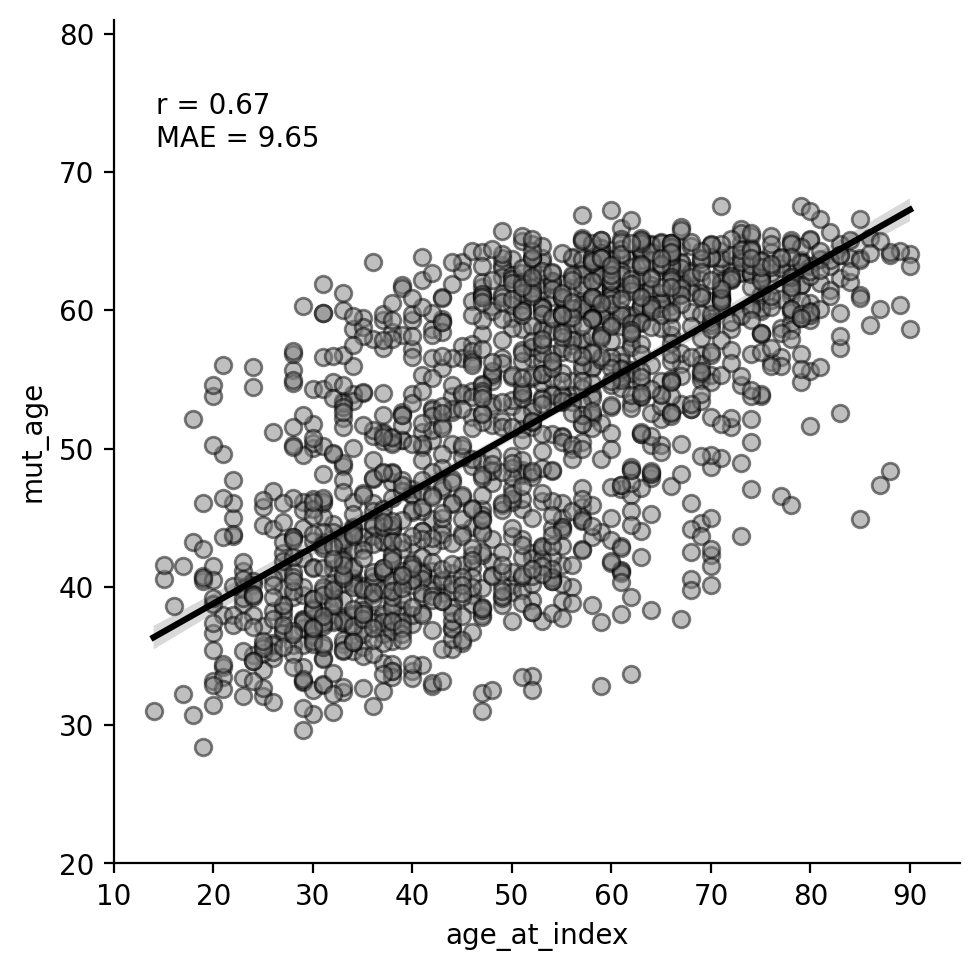

In [6]:
subset_tissues = combined_predictions_df.query("dataset in @dsets and tissue_type == 'cancer'")
sns.lmplot(
        data = subset_tissues, x = 'age_at_index', y = 'mut_age', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True, 'color': 'grey'},
        line_kws={'color':'black'}
        )
# add pearson corr and MAE to plot
r, p = pearsonr(subset_tissues['age_at_index'], subset_tissues['mut_age'])
mae = np.mean(np.abs(subset_tissues['age_at_index'] - subset_tissues['mut_age']))
# add to plot as text
plt.text(0.05, 0.85, f"r = {r:.2f}\nMAE = {mae:.2f}", transform=plt.gca().transAxes)
# set x and y ranges
plt.xlim(10,95)
plt.ylim(20,81)
# save as svg to fig_outdir
plt.savefig(os.path.join(fig_out_dir, "figure5b.svg"), format = 'svg')

# Figure 5c

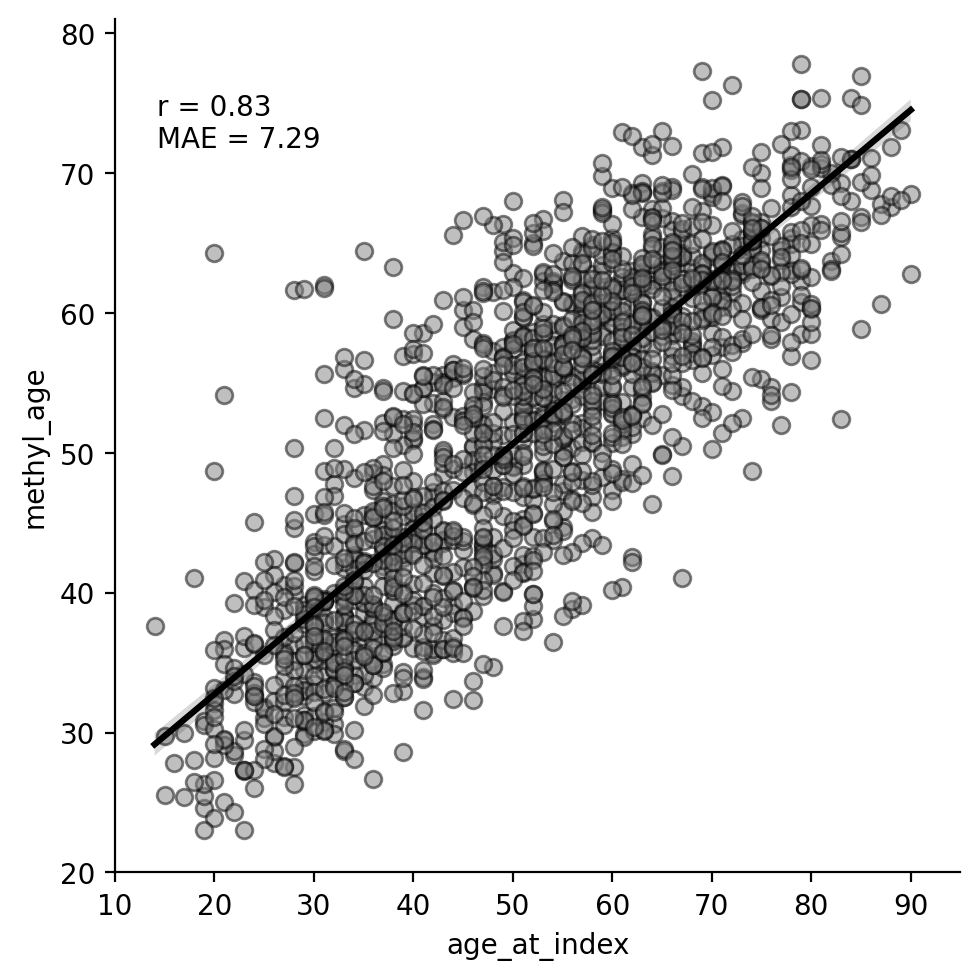

In [7]:

sns.lmplot(
        data = subset_tissues, x = 'age_at_index', y = 'methyl_age', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True, 'color': 'grey'},
        line_kws={'color':'black'}
        )
# add pearson corr and MAE to plot
r, p = pearsonr(subset_tissues['age_at_index'], subset_tissues['methyl_age'])
mae = np.mean(np.abs(subset_tissues['age_at_index'] - subset_tissues['methyl_age']))
# add to plot as text
plt.text(0.05, 0.85, f"r = {r:.2f}\nMAE = {mae:.2f}", transform=plt.gca().transAxes)
# set x and y ranges
plt.xlim(10,95)
plt.ylim(20,81)

plt.savefig(os.path.join(fig_out_dir, "figure5c.svg"), format = 'svg')


# Figure 5d

PearsonRResult(statistic=np.float64(0.45482075562963), pvalue=np.float64(1.4806102658800392e-82))
SignificanceResult(statistic=np.float64(0.44374858858347965), pvalue=np.float64(3.2321322335211706e-78))


/var/folders/xr/d_82j7h942xgvyqjprbpncg80000gn/T/ipykernel_12057/1020548482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_and_methyl_df['mut_age_resid'] = mut_regression.resid
/var/folders/xr/d_82j7h942xgvyqjprbpncg80000gn/T/ipykernel_12057/1020548482.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_and_methyl_df['methyl_age_resid'] = methyl_regression.resid
/var/folders/xr/d_82j7h942xgvyqjprbpncg80000gn/T/ipykernel_12057/1020548482.py:10: SettingWithCopyWarning: 
A value is trying to be se

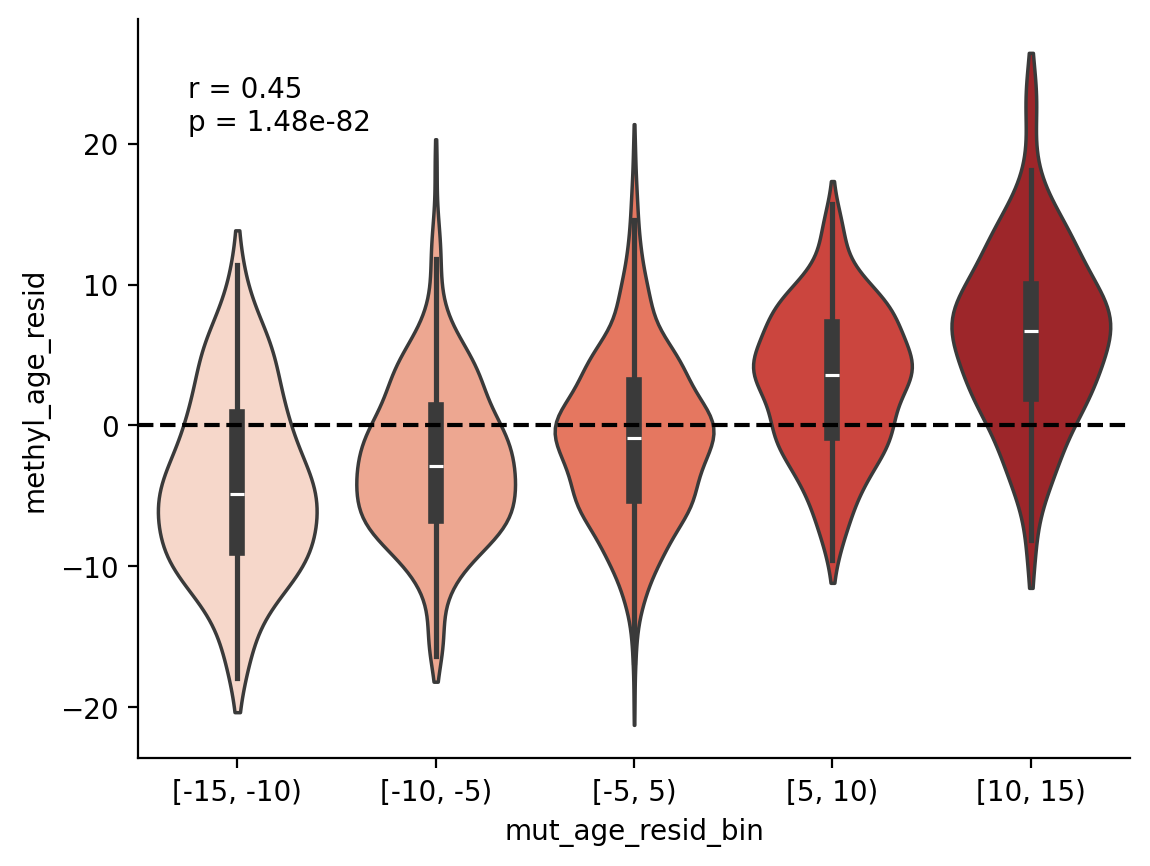

In [8]:
mut_and_methyl_df = combined_predictions_df.query("dataset in @dsets and tissue_type == 'cancer'")

mut_regression = smf.ols("mut_age ~ age_at_index", data = mut_and_methyl_df).fit()
mut_and_methyl_df['mut_age_resid'] = mut_regression.resid
# calculate residuals
methyl_regression = smf.ols("methyl_age ~ age_at_index", data = mut_and_methyl_df).fit()
mut_and_methyl_df['methyl_age_resid'] = methyl_regression.resid

# bin mutation age
mut_and_methyl_df['mut_age_resid_bin'] = mut_and_methyl_df['mut_age_resid'].transform(
                lambda x: pd.cut(x, bins =  [-15, -10, -5, 5,10,15],
                                 right=False, duplicates = 'drop',)
                )
sns.violinplot(
            data = mut_and_methyl_df,
            x = 'mut_age_resid_bin', y = 'methyl_age_resid', palette='Reds',
            cut = 1, 
            )
sns.despine()
print(pearsonr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid']))
print(spearmanr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid']))
# add pearsonr and pvalue to plot
r,p = pearsonr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid'])
plt.text(0.05, 0.85, f"r = {r:.2f}\np = {p:.2e}", transform=plt.gca().transAxes)
# add horizontal line at y = 0
plt.axhline(0, color = 'black', linestyle = '--')
plt.savefig(os.path.join(fig_out_dir, "figure5d.svg"), format = 'svg')

# Load TCGA data

In [ ]:
# NOTE: this data needs to be downloaded from TCGA, follow instructions in ./download_data/download_external.sh
# takes ~10 minutes
# methylation is quantile normalized

# cancer data
mut_w_age_df, illumina_cpg_locs_df, methyl_age_df_t, all_meta_df, _ = get_data.read_tcga_data()
methyl_age_df_t.index = methyl_age_df_t.index + "_cancer"
mut_w_age_df['chr'] = 'chr'+mut_w_age_df['chr']

# Figure 5e

In [8]:
horvath_clock = pd.read_csv("../data/existing_clocks/horvath.csv", skiprows=2)
pheno_clock = pd.read_csv("../data/existing_clocks/phenoAge_clock.csv")
hannum_clock = pd.read_csv("../data/existing_clocks/hannum_model.csv")
# get the clock CpGs for each
horvath_cpgs = horvath_clock.loc[1:, 'CpGmarker'].values
pheno_cpgs = pheno_clock.loc[1:, 'CpG'].values
hannum_cpgs = hannum_clock.loc[:, 'Marker'].values
# get the number of CpGs measured in TCGA data
measured_cpgs = methyl_age_df_t.columns
horvath_measured_cpgs = set(horvath_cpgs).intersection(set(measured_cpgs))
pheno_measured_cpgs = set(pheno_cpgs).intersection(set(measured_cpgs))  
hannum_measured_cpgs = set(hannum_cpgs).intersection(set(measured_cpgs))
# get the coefficients for each measured CpG
horvath_coefs = horvath_clock.query("CpGmarker in @horvath_measured_cpgs")['CoefficientTraining'].values
hovarth_intercept = horvath_clock.loc[0, 'CoefficientTraining']
pheno_coefs = pheno_clock.query("CpG in @pheno_measured_cpgs")['Weight'].values
pheno_intercept = pheno_clock.loc[0, 'Weight']
hannum_coefs = hannum_clock.query("Marker in @hannum_measured_cpgs")['Coefficient'].values
# do prediction on no drop TCGA data
horvath_pred = (methyl_age_df_t.loc[:, horvath_measured_cpgs]).dot(horvath_coefs) + hovarth_intercept
pheno_pred = methyl_age_df_t.loc[:, pheno_measured_cpgs].dot(pheno_coefs) + pheno_intercept
hannum_pred = methyl_age_df_t.loc[:, hannum_measured_cpgs].dot(hannum_coefs)
# add these as columnbs to no_drop_tcga_methyl_df_t
methyl_age_df_t['horvath_pred'] = horvath_pred
methyl_age_df_t['pheno_pred'] = pheno_pred
methyl_age_df_t['hannum_pred'] = hannum_pred
# print the frraction of CpGs measured in each clock
print(len(horvath_measured_cpgs)/len(horvath_cpgs))
print(len(pheno_measured_cpgs)/len(pheno_cpgs))
print(len(hannum_measured_cpgs)/len(hannum_cpgs))

0.71671388101983
0.6939571150097466
0.7605633802816901


/tmp/ipykernel_62574/1210112200.py:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  horvath_pred = (methyl_age_df_t.loc[:, horvath_measured_cpgs]).dot(horvath_coefs) + hovarth_intercept
/tmp/ipykernel_62574/1210112200.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  pheno_pred = methyl_age_df_t.loc[:, pheno_measured_cpgs].dot(pheno_coefs) + pheno_intercept
/tmp/ipykernel_62574/1210112200.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  hannum_pred = methyl_age_df_t.loc[:, hannum_measured_cpgs].dot(hannum_coefs)


In [9]:
# initialize empty dict of lists
pred_by_clock = {'Horvath-2013': [], 'PhenoAge': [], 'Hannum': []}
samples = []
these_tissues_methyl = methyl_age_df_t.query("dataset in @dsets")
for clock, cpgs in zip(['Horvath-2013', 'PhenoAge', 'Hannum'], [horvath_measured_cpgs, pheno_measured_cpgs, hannum_measured_cpgs]):
    # select only the CpGs in this clock
    these_tissues_methyl_clock = these_tissues_methyl.loc[:, cpgs]
    # do 5-fold CV training a linear regression model to predict age
    from sklearn.linear_model import ElasticNetCV, LinearRegression
    from sklearn.model_selection import KFold
    # do 5-fold CV
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    # loop
    for train_index, test_index in cv.split(these_tissues_methyl_clock):
        # split into train and test
        X_train, X_test = these_tissues_methyl_clock.iloc[train_index], these_tissues_methyl_clock.iloc[test_index]
        y_train, y_test = these_tissues_methyl.iloc[train_index]['age_at_index'], these_tissues_methyl.iloc[test_index]['age_at_index']
        test_dset = these_tissues_methyl.iloc[test_index]['dataset']
        # fit model
        ev = ElasticNetCV()
        #ev = LinearRegression()
        ev.fit(X_train, y_train)
        # predict
        y_pred = ev.predict(X_test)
        # add to dict
        pred_by_clock[clock].extend(y_pred)
        # if during the first clock, extend the actual ages 
        if clock == 'Horvath-2013':
            samples.extend(these_tissues_methyl.iloc[test_index].index.tolist())
        print("done CV", flush=True)
pred_by_clock_df = pd.DataFrame(pred_by_clock)
pred_by_clock_df['case_submitter_id'] = samples
pred_by_clock_df.set_index('case_submitter_id', inplace = True)
pred_by_clock_df['tissue'] = pred_by_clock_df.index.map(methyl_age_df_t['dataset'])
pred_by_clock_df['age_at_index'] = pred_by_clock_df.index.map(methyl_age_df_t['age_at_index'])
pred_by_clock_df['methyl_age'] = combined_predictions_df.query("dataset in @dsets")['methyl_age']
pred_by_clock_df['mut_age'] = combined_predictions_df.query("dataset in @dsets")['mut_age']
pred_by_clock_df.dropna(inplace = True)
pred_by_clock_df['tissue_type'] = pred_by_clock_df.index.str.split('_').str[1]

/tmp/ipykernel_62574/1757858618.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  these_tissues_methyl_clock = these_tissues_methyl.loc[:, cpgs]


done CV
done CV
done CV
done CV
done CV


/tmp/ipykernel_62574/1757858618.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  these_tissues_methyl_clock = these_tissues_methyl.loc[:, cpgs]


done CV
done CV
done CV
done CV
done CV


/tmp/ipykernel_62574/1757858618.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  these_tissues_methyl_clock = these_tissues_methyl.loc[:, cpgs]


done CV
done CV
done CV
done CV
done CV


In [10]:
pred_by_clock_df.rename({'methyl_age':'This study'}, axis = 1, inplace = True)
pred_by_clock_df.query("tissue_type == 'cancer'", inplace = True)
# new way
# calculate residual with age_at_index for Horvath-2013, PhenoAge, Hannum, This study, and mut_age
pred_by_clock_df.rename(columns = {'Horvath-2013':'Horvath', 'This study':'This_study'}, inplace = True)
for clock in ['Horvath', 'PhenoAge', 'Hannum', 'This_study',  'mut_age']:
    # do ols
    ols = smf.ols(f"{clock} ~ age_at_index", data = pred_by_clock_df).fit()
    # add residual to pred_by_clock_df
    pred_by_clock_df[f"{clock}_resid"] = ols.resid
pred_by_clock_df.rename(columns = {'Horvath':'Horvath-2013', 'This_study':'This study'}, inplace = True)

# pivot to long format, so each row is pred of one clock, age_at_index, and tissue
pred_by_clock_df_long = pred_by_clock_df.melt(id_vars = ['age_at_index', 'tissue'], value_vars = ['Horvath-2013',  'PhenoAge', 'Hannum', 'This study',], var_name = 'Clock', value_name = 'pred_age', ignore_index = False)
# also get resids in this format
pred_by_clock_df_long_resid = pred_by_clock_df.melt(id_vars = ['age_at_index', 'tissue'], value_vars = ['Horvath_resid', 'PhenoAge_resid', 'Hannum_resid', 'This_study_resid',], var_name = 'Clock', value_name = 'pred_age_resid', ignore_index = False)
# combine these dfs
pred_by_clock_df_long['pred_age_resid'] = pred_by_clock_df_long_resid['pred_age_resid']
# add mut_age and mut_age_resid
pred_by_clock_df_long['mut_age'] = pred_by_clock_df_long.index.map(pred_by_clock_df['mut_age'])
pred_by_clock_df_long['mut_age_resid'] = pred_by_clock_df_long.index.map(pred_by_clock_df['mut_age_resid'])


# bin mut_age_resid into 5 bins, within each clock
pred_by_clock_df_long['mut_age_resid_bin'] = pred_by_clock_df_long.groupby('Clock')['mut_age_resid'].transform(
    lambda x: pd.qcut(x, q = 5, duplicates = 'drop', labels = ['Low', '1','2', '3', 'High'])
    )
# only keep low and high
pred_by_clock_df_long = pred_by_clock_df_long.query('mut_age_resid_bin == "Low" or mut_age_resid_bin == "High"')
pred_by_clock_df_long['clock_plus_bin'] = pred_by_clock_df_long['Clock'] + '_' + pred_by_clock_df_long['mut_age_resid_bin'].astype(str)

                   count      mean       std        min       25%       50%  \
clock_plus_bin                                                                
Hannum_High        320.0  5.239320  8.196469 -22.530912  0.245052  4.687821   
Hannum_Low         321.0 -4.587432  5.190844 -22.168071 -7.794398 -4.512541   
Horvath-2013_High  320.0  5.982465  7.372260 -13.560055  0.902149  5.307753   
Horvath-2013_Low   321.0 -5.161162  5.555973 -22.585852 -8.776102 -5.059180   
PhenoAge_High      320.0  6.549902  7.844469  -8.591276  1.622945  5.682960   
PhenoAge_Low       321.0 -5.159721  4.979375 -23.157247 -8.809985 -5.180348   
This study_High    320.0  5.020515  6.341237  -9.539339  0.592021  4.795778   
This study_Low     321.0 -3.356511  5.937530 -17.914208 -7.482341 -3.603106   

                         75%        max  
clock_plus_bin                           
Hannum_High        10.099258  37.604853  
Hannum_Low         -1.307091  12.211776  
Horvath-2013_High  10.769341  30.472620  

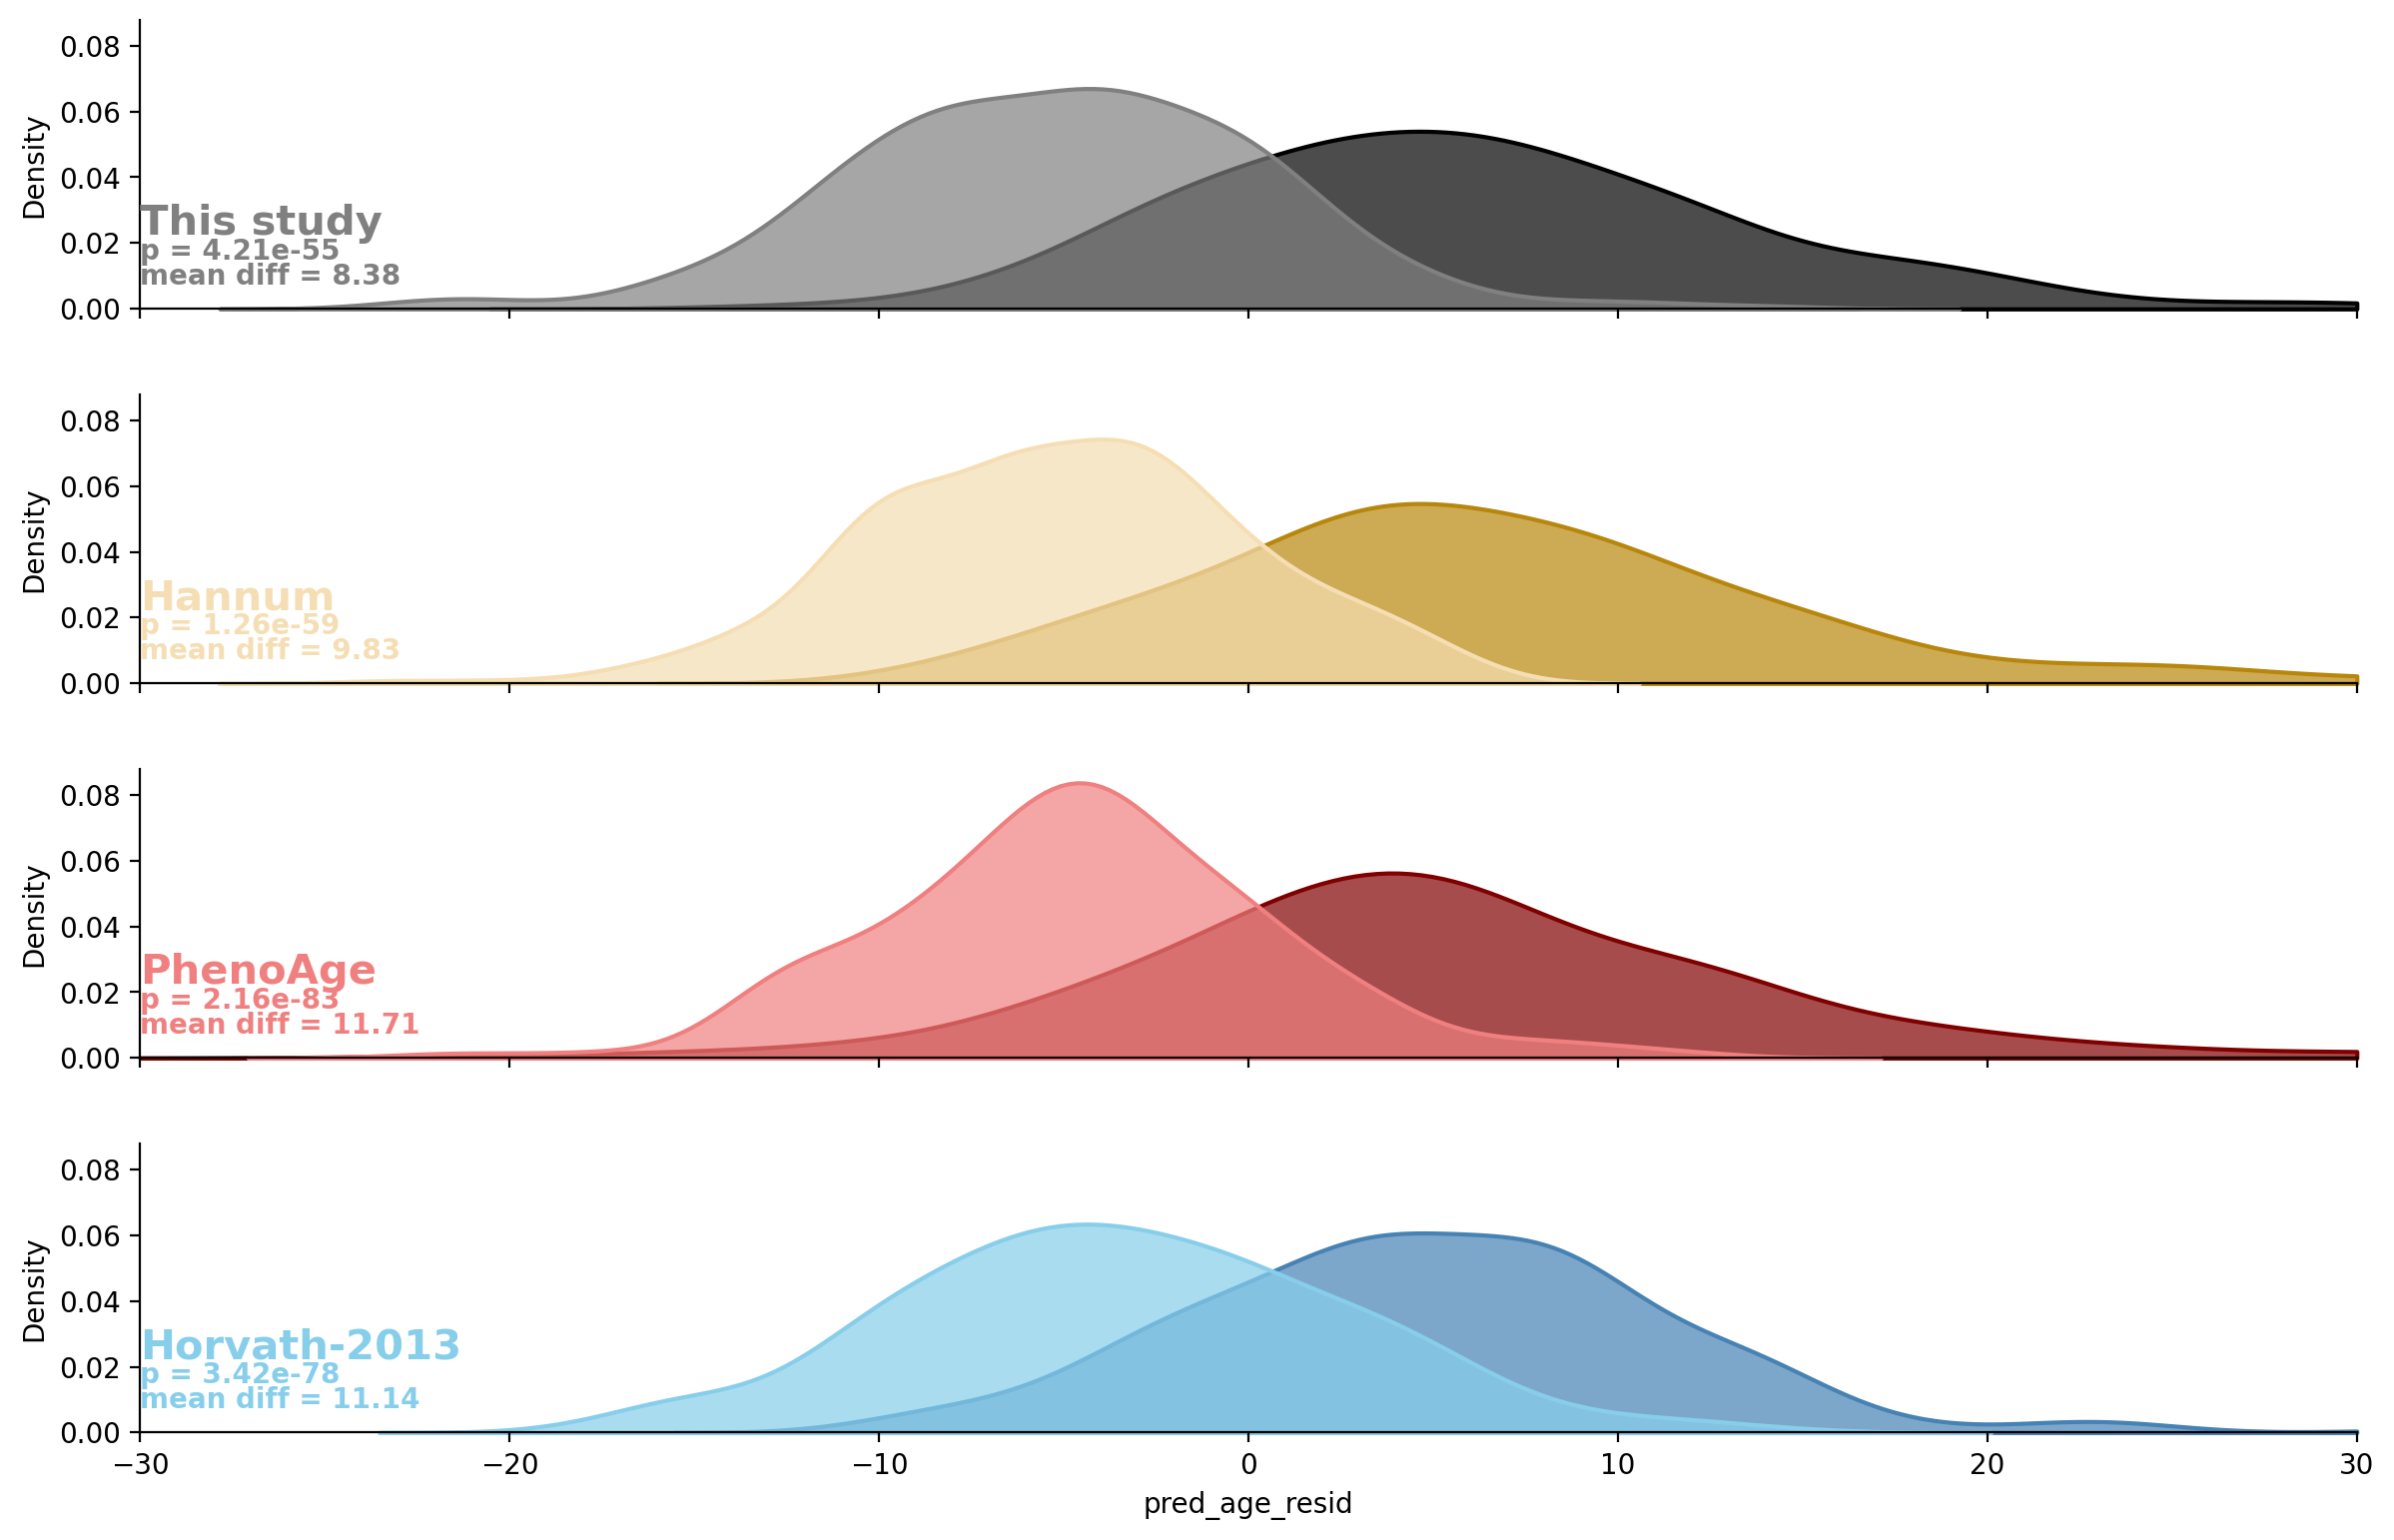

In [11]:
# binning by mutation age residual
all_clocks_pred_results_df = pred_by_clock_df_long
g = sns.FacetGrid(
    all_clocks_pred_results_df, row='Clock', hue='clock_plus_bin', hue_order=['This study_High', 'This study_Low', 'Hannum_High',  'Hannum_Low', 'PhenoAge_High', 'PhenoAge_Low', 'Horvath-2013_High', 'Horvath-2013_Low'], aspect=6, height=2, palette = [ 'steelblue', 'skyblue','maroon', 'lightcoral', 'darkgoldenrod', 'wheat','black',  'grey'])
    #aspect=6, height=2,)# palette = ['black', 'grey',  'steelblue', 'skyblue','maroon', 'lightcoral', 'darkgoldenrod', 'wheat']
    

# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'pred_age_resid',
      bw_adjust=1, clip_on=False,
      # different palette for each plot
      fill=True, alpha=0.7, linewidth=1.5,
      hue_order = ['Low',  'High'], clip = (-30, 30)
      )

g.fig.subplots_adjust(hspace=-1)

# here we add a horizontal line for each plot
g.map(
      plt.axhline, y=0,
      lw=0.0001, clip_on=False, alpha = 1
      )

# we loop over the FacetGrid figure axes (g.axes.flat) and add the clock as text with the right color
# notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
clock_dict ={
    1: 'This study',
    2: 'Hannum',
    3: 'PhenoAge',
    4: 'Horvath-2013',
}

# t-test between high and low within each clock
from scipy.stats import ttest_ind

p_vals = []
mean_diffs = []
for clock in clock_dict.values():
    p_vals.append(ttest_ind(
        all_clocks_pred_results_df.query(f'Clock == "{clock}" and mut_age_resid_bin == "High"')['pred_age_resid'],
        all_clocks_pred_results_df.query(f'Clock == "{clock}" and mut_age_resid_bin == "Low"')['pred_age_resid']
        ).pvalue)
    # difference of means
    mean_diffs.append(float(all_clocks_pred_results_df.query(f'Clock == "{clock}" and mut_age_resid_bin == "High"')['pred_age_resid'].mean() - all_clocks_pred_results_df.query(f'Clock == "{clock}" and mut_age_resid_bin == "Low"')['pred_age_resid'].mean()))

for i, ax in enumerate(g.axes.flat):
    ax.text(-30, 0.0225, clock_dict[i+1],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())
    # also add p value and mean difference
    ax.text(-30, 0.015, f"p = {p_vals[i]:.2e}",
            fontweight='bold', fontsize=10,
            color=ax.lines[-1].get_color())
    ax.text(-30, 0.0075, f"mean diff = {mean_diffs[i]:.2f}",
            fontweight='bold', fontsize=10,
            color=ax.lines[-1].get_color())
    
plt.xlim(-30, 30)
# eventually we remove axes titles, yticks and spines
g.set_titles("")
#g.set(yticks=[])
#g.despine(bottom=True, left=False)
# save to svg
plt.savefig(os.path.join(fig_out_dir,"figure5e.svg"), format = 'svg')

print(all_clocks_pred_results_df.groupby('clock_plus_bin')['pred_age_resid'].describe())

# Figure 5f

In [12]:
mut_clock_binary = mutation_clocks.mutationBurdenClock(
    all_methyl_age_df_t = methyl_age_df_t,
    mut_burden_dir = "../data/feature_matrices", 
    corr_dir = "",
    consoritum = "tcga",
    tissues = dsets,
    max_dist = 10000
)
mut_clock_binary.mut_count_w_pred_results_df = pd.read_parquet("../data/feature_matrices/mut_count_w_pred_results_df.parquet")
mut_clock_binary.methyl_mat_w_pred_results_df = pd.read_parquet("../data/feature_matrices/methyl_mat_w_pred_results_df_rounded.parquet")

In [13]:
def read_mut_mi_df(tissues):
    all_mut_mi_dfs = []
    for tissue in tissues:
        mi_mut = pd.read_parquet(f"../data/mutual_information/mut_vs_age/{tissue}.parquet")
        mi_mut.columns = [tissue]
        all_mut_mi_dfs.append(mi_mut)
    # concat side by side
    all_mut_mi_df = pd.concat(all_mut_mi_dfs, axis = 1)
    all_mut_mi_df['mean_mi'] = all_mut_mi_df.mean(axis = 1)
    
    mut_feats = all_mut_mi_df.index.to_list()
    methyl_features = mut_clock_binary.methyl_mat_w_pred_results_df.columns.to_list()
    shared_features = list(set(mut_feats) & set(methyl_features))
    # sort shared features by mutual info
    all_mut_mi_df = all_mut_mi_df.loc[shared_features].sort_values('mean_mi', ascending = False)
    return all_mut_mi_df

def read_methyl_mi_df(tissues):
    all_methyl_mi_dfs = []
    for tissue in tissues:
        mi_methyl = pd.read_parquet(f"../data/mutual_information/methyl_vs_age/methyl_{tissue}.parquet")
        mi_methyl.columns = [tissue]
        all_methyl_mi_dfs.append(mi_methyl)
    # concat side by side
    all_methyl_mi_df = pd.concat(all_methyl_mi_dfs, axis = 1)
    all_methyl_mi_df['mean_mi'] = all_methyl_mi_df.mean(axis = 1)
    
    methyl_feats = all_methyl_mi_df.index.to_list()
    mut_features = mut_clock_binary.mut_count_w_pred_results_df.columns.to_list()
    shared_features = list(set(methyl_feats) & set(mut_features))
    # sort shared features by mutual info
    all_methyl_mi_df = all_methyl_mi_df.loc[shared_features].sort_values('mean_mi', ascending = False)
    return all_methyl_mi_df

def read_mut_methyl_mi_df(tissues):
    all_methyl_mi_dfs = []
    for tissue in tissues:
        mi_methyl = pd.read_parquet(f"../data/mutual_information/mut_vs_methyl/{tissue}_mut_methyl.parquet")
        mi_methyl.columns = [tissue]
        all_methyl_mi_dfs.append(mi_methyl)
    # concat side by side
    all_methyl_mi_df = pd.concat(all_methyl_mi_dfs, axis = 1)
    all_methyl_mi_df['mean_mi'] = all_methyl_mi_df.mean(axis = 1)
    
    methyl_feats = all_methyl_mi_df.index.to_list()
    mut_features = mut_clock_binary.mut_count_w_pred_results_df.columns.to_list()
    shared_features = list(set(methyl_feats) & set(mut_features))
    # sort shared features by mutual info
    all_methyl_mi_df = all_methyl_mi_df.loc[shared_features].sort_values('mean_mi', ascending = False)
    return all_methyl_mi_df

# read in and combine all the mutual information dfs
mut_mi_df = read_mut_mi_df(tissues = dsets)
methyl_mi_df = read_methyl_mi_df(tissues = dsets)
combined_mi_df = mut_mi_df.merge(
    methyl_mi_df, suffixes=('_mut', '_methyl'),
    left_index=True, right_index=True
    )
mut_methyl_mi_df = read_mut_methyl_mi_df(tissues = dsets)

combined_mi_df = combined_mi_df.merge(
    mut_methyl_mi_df, suffixes=('', '_mut-methyl'),
    left_index=True, right_index=True
    )
# append _mut-methyl to last 6 column names
combined_mi_df.columns = combined_mi_df.columns.to_series().apply(lambda x: x + '_mut-methyl' if x in combined_mi_df.columns[-6:] else x)

chosen_site_count = []
shared_count = []
top_percentages = []
total_sites = len(combined_mi_df)
for perc in .01, .05, .1:
    number_to_choose = int(perc*total_sites)
    # choose top from each category
    top_mut = combined_mi_df.sort_values(f'mean_mi_mut', ascending = False).head(number_to_choose).index.to_list()
    top_methyl = combined_mi_df.sort_values(f'mean_mi_methyl', ascending = False).head(number_to_choose).index.to_list()
    # then we look at how many of these sites overlap
    shared_sites = list(set(top_mut).intersection(set(top_methyl)))
    chosen_site_count.append(number_to_choose)
    shared_count.append(len(shared_sites))
    top_percentages.append(perc)
overlap_df = pd.DataFrame({'chosen_site_count': chosen_site_count, 'shared_count': shared_count, 'top_percentages': top_percentages})

0     6.846313e-13
1    9.460411e-141
2     0.000000e+00
Name: binom_p, dtype: float64


/tmp/ipykernel_62574/2060640510.py:6: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  overlap_df['binom_p'] = overlap_df.apply(lambda x: binom_test(x['shared_count'], x['chosen_site_count'], x['top_percentages']**2), axis = 1)
/tmp/ipykernel_62574/2060640510.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = overlap_df, x = 'top_percentages', y = 'observed_over_expected', palette='Blues_r', edgecolor = 'black', ax=axes)


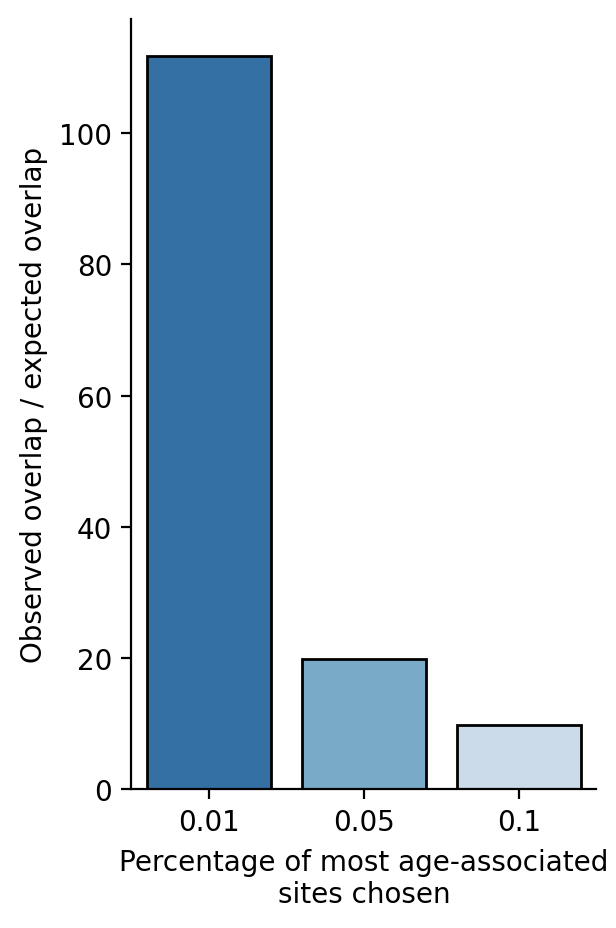

In [14]:
overlap_df['prop_shared'] = overlap_df['shared_count']/overlap_df['chosen_site_count']
overlap_df['expected_prop_shared'] = overlap_df['top_percentages']**2
overlap_df['observed_over_expected'] = overlap_df['prop_shared']/overlap_df['expected_prop_shared']
# calculate a binomial test for each
from scipy.stats import binom_test
overlap_df['binom_p'] = overlap_df.apply(lambda x: binom_test(x['shared_count'], x['chosen_site_count'], x['top_percentages']**2), axis = 1)
print(overlap_df['binom_p'])
fig, axes = plt.subplots(1,1, figsize = (3,5))
sns.barplot(data = overlap_df, x = 'top_percentages', y = 'observed_over_expected', palette='Blues_r', edgecolor = 'black', ax=axes)
plt.ylabel('Observed overlap / expected overlap')
plt.xlabel('Percentage of most age-associated\nsites chosen')
plt.savefig(f"{fig_out_dir}/figure5f.svg", dpi = 300, format = 'svg')
sns.despine()

/tmp/ipykernel_350473/1340835700.py:26: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  overlap_df['binom_p'] = overlap_df.apply(lambda x: binom_test(x['shared_count'], x['chosen_site_count'], x['top_percentages']**2), axis = 1)
/tmp/ipykernel_350473/1340835700.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = overlap_df, x = 'top_percentages', y = 'observed_over_expected', palette='Blues_r', edgecolor = 'black', ax=axes)


0     3.846938e-05
1    6.308546e-196
2     0.000000e+00
Name: binom_p, dtype: float64


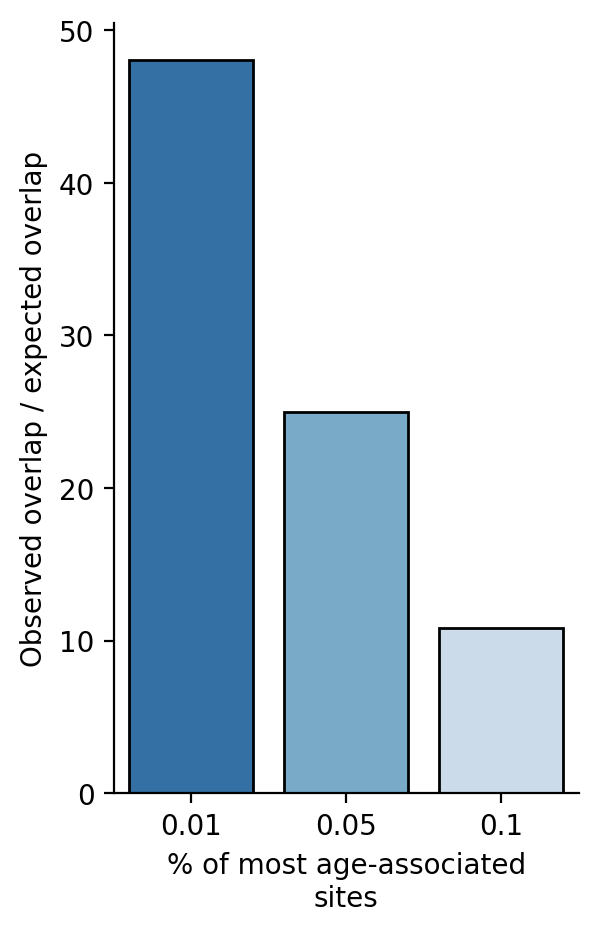

In [4]:
methyl_pearson_corrs = pd.read_parquet("../data/pearson_correlation/methyl_pearson_corrs.parquet")
mut_pearson_corrs = pd.read_parquet("../data/pearson_correlation/mut_pearson_corrs.parquet")
p_corrs = methyl_pearson_corrs.merge(mut_pearson_corrs, left_index = True, right_index = True, how = 'inner')

chosen_site_count = []
shared_count = []
top_percentages = []
total_sites = len(p_corrs)
for perc in .01, .05, .1:
    number_to_choose = int(perc*total_sites)
    # choose top from each category
    top_mut = p_corrs.sort_values(f'mut_corr', ascending = False).head(number_to_choose).index.to_list()
    top_methyl = p_corrs.sort_values(f'methyl_corr', ascending = False).head(number_to_choose).index.to_list()
    # then we look at how many of these sites overlap
    shared_sites = list(set(top_mut).intersection(set(top_methyl)))
    chosen_site_count.append(number_to_choose)
    shared_count.append(len(shared_sites))
    top_percentages.append(perc)
overlap_df = pd.DataFrame({'chosen_site_count': chosen_site_count, 'shared_count': shared_count, 'top_percentages': top_percentages})

overlap_df['prop_shared'] = overlap_df['shared_count']/overlap_df['chosen_site_count']
overlap_df['expected_prop_shared'] = overlap_df['top_percentages']**2
overlap_df['observed_over_expected'] = overlap_df['prop_shared']/overlap_df['expected_prop_shared']
# calculate a binomial test for each
from scipy.stats import binom_test
overlap_df['binom_p'] = overlap_df.apply(lambda x: binom_test(x['shared_count'], x['chosen_site_count'], x['top_percentages']**2), axis = 1)
print(overlap_df['binom_p'])
fig, axes = plt.subplots(1,1, figsize = (3,5))
sns.barplot(data = overlap_df, x = 'top_percentages', y = 'observed_over_expected', palette='Blues_r', edgecolor = 'black', ax=axes)
plt.ylabel('Observed overlap / expected overlap')
plt.xlabel('% of most age-associated\nsites')
plt.savefig(f"{fig_out_dir}/figure5f.svg", dpi = 300, format = 'svg')
sns.despine()

0     7.368487e-09
1    8.585093e-182
2     0.000000e+00
Name: binom_p, dtype: float64


/tmp/ipykernel_350473/1792155757.py:26: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  overlap_df['binom_p'] = overlap_df.apply(lambda x: binom_test(x['shared_count'], x['chosen_site_count'], x['top_percentages']**2), axis = 1)
/tmp/ipykernel_350473/1792155757.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = overlap_df, x = 'top_percentages', y = 'observed_over_expected', palette='Blues_r', edgecolor = 'black', ax=axes)


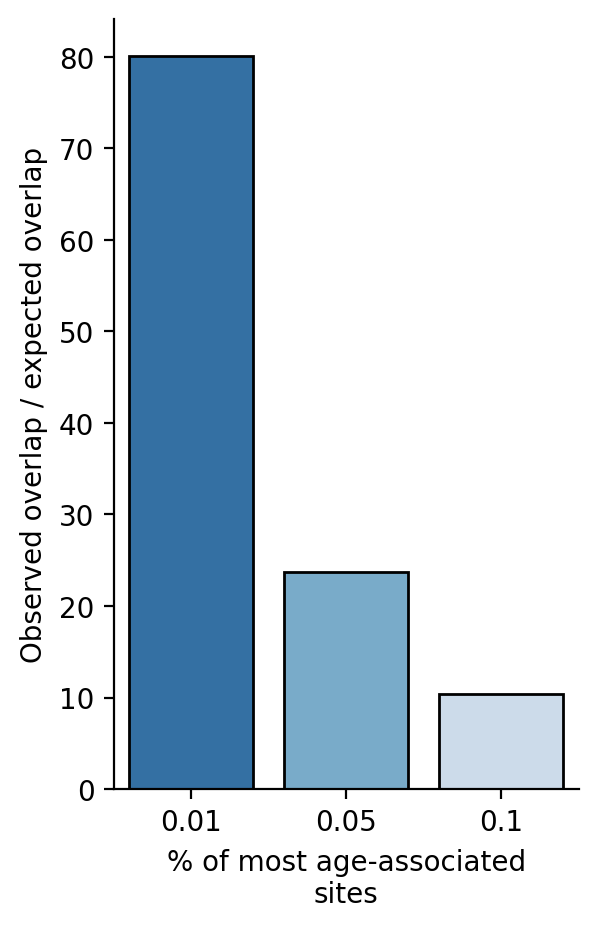

In [7]:
methyl_pearson_corrs = pd.read_parquet("../data/pearson_correlation/methyl_pearson_corrs.parquet")
qnorm_mut_pearson_corrs = pd.read_parquet("../data/pearson_correlation/qnorm_mut_corrs.parquet")
p_corrs = methyl_pearson_corrs.merge(qnorm_mut_pearson_corrs, left_index = True, right_index = True, how = 'inner')

chosen_site_count = []
shared_count = []
top_percentages = []
total_sites = len(p_corrs)
for perc in .01, .05, .1:
    number_to_choose = int(perc*total_sites)
    # choose top from each category
    top_mut = p_corrs.sort_values(f'qnorm_mut_corr', ascending = False).head(number_to_choose).index.to_list()
    top_methyl = p_corrs.sort_values(f'methyl_corr', ascending = False).head(number_to_choose).index.to_list()
    # then we look at how many of these sites overlap
    shared_sites = list(set(top_mut).intersection(set(top_methyl)))
    chosen_site_count.append(number_to_choose)
    shared_count.append(len(shared_sites))
    top_percentages.append(perc)
overlap_df = pd.DataFrame({'chosen_site_count': chosen_site_count, 'shared_count': shared_count, 'top_percentages': top_percentages})

overlap_df['prop_shared'] = overlap_df['shared_count']/overlap_df['chosen_site_count']
overlap_df['expected_prop_shared'] = overlap_df['top_percentages']**2
overlap_df['observed_over_expected'] = overlap_df['prop_shared']/overlap_df['expected_prop_shared']
# calculate a binomial test for each
from scipy.stats import binom_test
overlap_df['binom_p'] = overlap_df.apply(lambda x: binom_test(x['shared_count'], x['chosen_site_count'], x['top_percentages']**2), axis = 1)
print(overlap_df['binom_p'])
fig, axes = plt.subplots(1,1, figsize = (3,5))
sns.barplot(data = overlap_df, x = 'top_percentages', y = 'observed_over_expected', palette='Blues_r', edgecolor = 'black', ax=axes)
plt.ylabel('Observed overlap / expected overlap')
plt.xlabel('% of most age-associated\nsites')
plt.savefig(f"{fig_out_dir}/figure5f.svg", dpi = 300, format = 'svg')
sns.despine()

# Figure 5g

In [16]:
non_binary_mut_counts = pd.read_parquet("../data/feature_matrices/mut_count_w_pred_results_df_nonbin.parquet")
# subset to only include example tissue
this_dset_methyl = methyl_age_df_t.query("dataset in ['LGG']")
this_dset_mut_counts = non_binary_mut_counts.query("tissue in ['LGG'] and this_cv_test_sample == True")
# remove _cancer or _normal from index of this_dset_methyl
this_dset_methyl.index = this_dset_methyl.index.str.replace('_cancer', '').str.replace('_normal', '')

example_region = 'cg19236454'
# combine
tp = this_dset_methyl[example_region].to_frame().merge(this_dset_mut_counts[[example_region, 'age_at_index']], left_index = True, right_index = True, suffixes = ('_methyl', '_mut')).rename(columns = {'cg19236454_methyl':'methyl', 'cg19236454_mut':'mut'})

/tmp/ipykernel_62574/2571487167.py:12: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data = tp_long, x = 'age_bin', y = 'Value', hue = '-omic', join = True, palette = ['maroon', 'steelblue'], dodge = 0.05, errorbar='se', ax = axes)


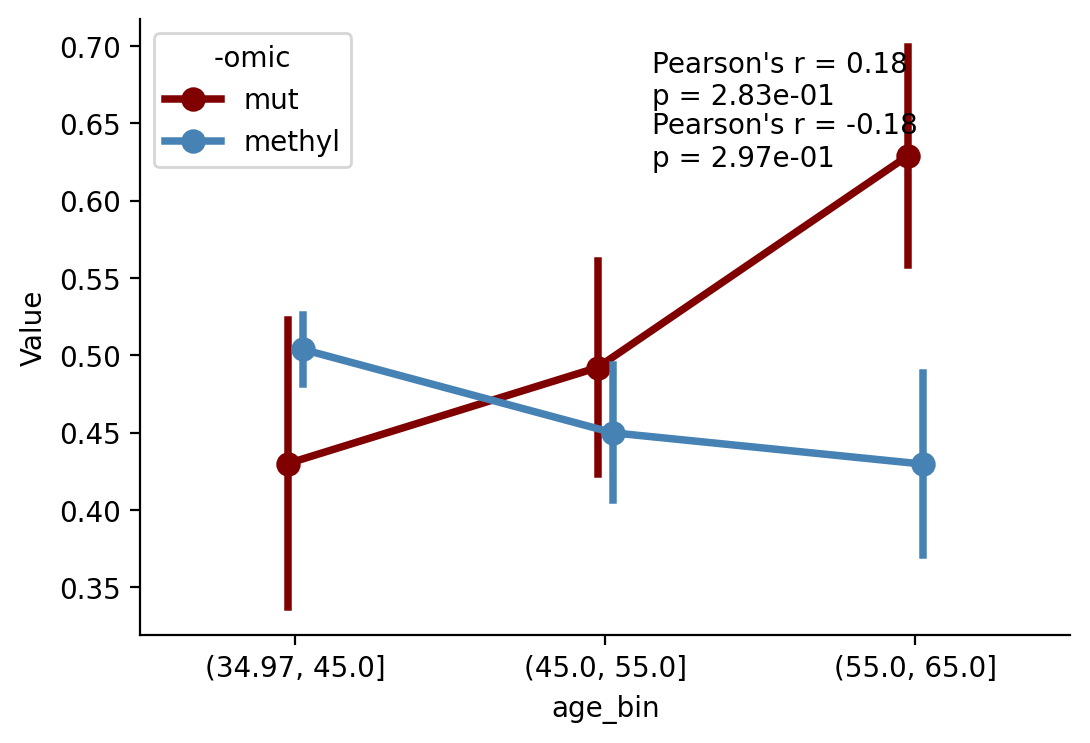

In [17]:
fig, axes = plt.subplots(figsize = (6,4),)
# one that is methyl vs age and mut vs. age, grouped
tp['age_bin'] = pd.cut(
    tp.query("mut > 0 and age_at_index >= 35 and age_at_index <=65")['age_at_index'], bins = 3
    )
tpp = tp.reset_index(drop = False).rename(columns = {'index':'Individual'})
# and age_at_index >= 35 and age_at_index <=65
tp_long = pd.melt(tpp.query("mut > 0 and age_at_index >= 35 and age_at_index <=65"), id_vars=['age_bin', 'Individual'], value_vars=['mut', 'methyl'],
                  var_name='-omic', value_name='Value')
# add a little jitter
# make slight transparency
sns.pointplot(data = tp_long, x = 'age_bin', y = 'Value', hue = '-omic', join = True, palette = ['maroon', 'steelblue'], dodge = 0.05, errorbar='se', ax = axes)
sns.despine()

# add correlation of methyl and mut with age to plot
r_mut = pearsonr(tp.query("mut > 0 and age_at_index >= 35 and age_at_index <=65")['age_at_index'], tp.query("mut > 0 and age_at_index >= 35 and age_at_index <=65")['mut']).correlation
p_mut = pearsonr(tp.query("mut > 0 and age_at_index >= 35 and age_at_index <=65")['age_at_index'], tp.query("mut > 0 and age_at_index >= 35 and age_at_index <=65")['mut']).pvalue
r_methyl = pearsonr(tp.query("mut > 0 and age_at_index >= 35 and age_at_index <=65")['age_at_index'], tp.query("mut > 0 and age_at_index >= 35 and age_at_index <=65")['methyl']).correlation
p_methyl = pearsonr(tp.query("mut > 0 and age_at_index >= 35 and age_at_index <=65")['age_at_index'], tp.query("mut > 0 and age_at_index >= 35 and age_at_index <=65")['methyl']).pvalue
# add to plot in upper rifght
plt.text(0.55, 0.95, f"Pearson's r = {r_mut:.2f}\np = {p_mut:.2e}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.55, 0.85, f"Pearson's r = {r_methyl:.2f}\np = {p_methyl:.2e}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.savefig(f"{fig_out_dir}/figure5g.svg", dpi = 300, format = 'svg')